Generate a `requires_tags` column for the Providence and Manchester corpora by
- Filtering to words in the McArthur Communicative Development Index (CDI) (inflections okay)
- Subsampling to 100 instances per speaker-interval (month)

The logic here will be implemented in `ws_web/preprocessing_scripts/populate_derived_tokens.py`

In [43]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
import postgres_config
import numpy as np
import mysql_config
import imp
imp.reload(mysql_config)
from sqlalchemy import create_engine
import analysis_helper #all of the good and useful code
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2

/home/stephan/python/WordSense/lib/python3.5/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 version 3.1.0 but you have 3.2.1
  'have %s' % (TARGET_VERSION, ggplot2.__version__))


In [2]:
# Postgres connection to Word Sense (SQLAlchemy)
wordsense_auth = postgres_config.Authenticator('WordSense')
ws_engine = create_engine(wordsense_auth.connectionString)

# Connection to childes-db
childesdb_auth  = mysql_config.Authenticator('ec2')
cdb_engine = create_engine(childesdb_auth.connectionString)

/home/stephan/python/WordSense/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [132]:
childes_to_wordnet_pos = {"adj": wordnet.ADJ,
    "n": wordnet.NOUN,
    "v": wordnet.VERB,
    "adv": wordnet.ADV}

cdi_items = pd.read_csv('../../data/WSWG_50percentproducing.csv')

In [5]:
man_tokens = analysis_helper.getTokensForCorpus('Manchester', cdb_engine)

In [7]:
pvd_tokens = analysis_helper.getTokensForCorpus('Providence', cdb_engine)

In [11]:
imp.reload(analysis_helper)
pos_map = pd.DataFrame({'full_pos':np.unique(pd.concat([man_tokens, pvd_tokens]).part_of_speech)})
pos_map['short_pos'] = [analysis_helper.downsample_pos(x, childes_to_wordnet_pos) for x in pos_map.full_pos]

Not recognized! 
Not recognized! L2
Not recognized! adj adj v
Not recognized! adj aux
Not recognized! adj cop
Not recognized! adj inf
Not recognized! adj n
Not recognized! adj prep
Not recognized! adj pro:indef
Not recognized! adv adv
Not recognized! adv aux
Not recognized! adv cop
Not recognized! adv det:poss
Not recognized! adv mod
Not recognized! adv prep
Not recognized! adv prep det:art
Not recognized! adv pro:per v
Not recognized! adv pro:sub
Not recognized! aux
Not recognized! aux cop
Not recognized! aux inf
Not recognized! aux neg
Not recognized! aux prep
Not recognized! aux pro:per
Not recognized! aux pro:per co
Not recognized! bab
Not recognized! chi
Not recognized! co
Not recognized! co co
Not recognized! co cop
Not recognized! conj
Not recognized! conj aux
Not recognized! conj pro:per
Not recognized! conj pro:per cop
Not recognized! coord
Not recognized! coord adv:tem
Not recognized! coord det:art
Not recognized! coord pro:sub
Not recognized! cop
Not recognized! cop neg
Not 

In [133]:
pos_map

,full_pos,short_pos
0,,None
1,L2,None
2,adj,adj
3,adj adj v,None
4,adj aux,None
5,adj cop,None
6,adj inf,None
7,adj n,None
8,adj prep,None
9,adj pro:indef,None


In [109]:
imp.reload(analysis_helper)
pvd_counts, pvd_ids = analysis_helper.subsampleCorpus(pvd_tokens, cdi_items['uni_lemma'],
    3, [['CHI'],['MOT','FAT']],  50, pos_map, childes_to_wordnet_pos)

Adding columns necessary for derived_tokens...
Filtering words....
Specified interval of 3 months....
Stratifying by speaker_group....
Getting aggregate counts (`max_tokens_per_interval` will not be used)
Aggregating by:
['time_interval', 'speaker_group']


In [112]:
num_pvd_subsampled = len(pvd_ids)
%R -i num_pvd_subsampled,pvd_counts

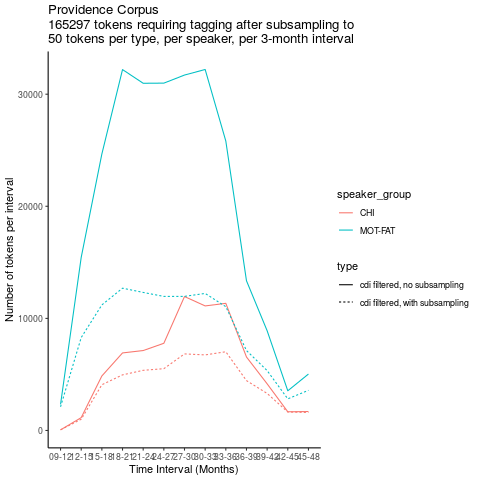

In [127]:
%%R
names(pvd_counts) = c('time_interval','speaker_group','token_count','type')
pvd_counts$speaker_and_type = paste(pvd_counts$speaker_group,'-', pvd_counts$type)
options(repr.plot.width=8, repr.plot.height=6)
ggplot(pvd_counts) + geom_line(aes(x=time_interval, y=token_count, 
colour=speaker_group, linetype=type, group=speaker_and_type)) + theme_classic(
) + ylab('Number of tokens per interval') + xlab ('Time Interval (Months)'
) + ggtitle(paste('Providence Corpus\n',num_pvd_subsampled,' tokens requiring tagging after subsampling to \n50 tokens per type, per speaker, per 3-month interval', sep=''))

##) + geom_point(aes(x=time_interval, y=token_count, 
# colour=speaker_group)) + theme_classic()

In [128]:
man_counts, man_ids = analysis_helper.subsampleCorpus(man_tokens, cdi_items['uni_lemma'],
    3, [['CHI'],['MOT','FAT']],  50, pos_map, childes_to_wordnet_pos)

Adding columns necessary for derived_tokens...
Filtering words....
Specified interval of 3 months....
Stratifying by speaker_group....
Getting aggregate counts (`max_tokens_per_interval` will not be used)
Aggregating by:
['time_interval', 'speaker_group']


In [129]:
num_man_subsampled = len(man_ids)
%R -i num_man_subsampled,man_counts

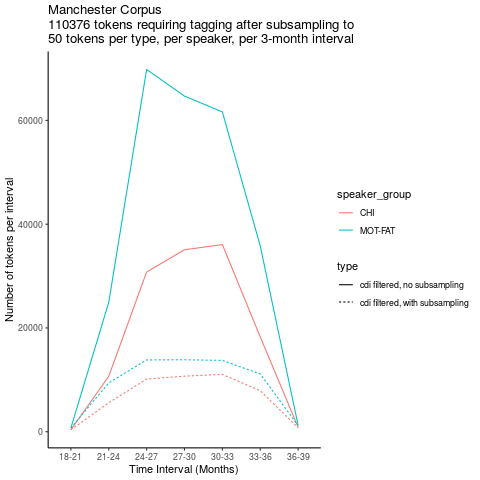

In [131]:
%%R
names(man_counts) = c('time_interval','speaker_group','token_count','type')
man_counts$speaker_and_type = paste(man_counts$speaker_group,'-', man_counts$type)
options(repr.plot.width=8, repr.plot.height=6)
ggplot(man_counts) + geom_line(aes(x=time_interval, y=token_count, 
colour=speaker_group, linetype=type, group=speaker_and_type)) + theme_classic(
) + ylab('Number of tokens per interval') + xlab ('Time Interval (Months)'
) + ggtitle(paste('Manchester Corpus\n',num_man_subsampled,' tokens requiring tagging after subsampling to \n50 tokens per type, per speaker, per 3-month interval', sep=''))


##) + geom_point(aes(x=time_interval, y=token_count, 
# colour=speaker_group)) + theme_classic()

In [ ]:
# [X] how to know which words have multiple senses? We don't! we gather responses 
    # for all of them because we may be missing senses
# [ ] do some time / cost estimates